In [42]:
import backtrader as bt
import pandas as pd
import pyfolio as pf

import warnings
warnings.filterwarnings('ignore')

ticker1 = 'ANET'
ticker2 = 'KKR'

In [51]:
prices = pd.read_parquet('../data/sp500_2025-01-01_2025-07-01.parquet')
ticker1_prices = prices.xs(ticker1, axis=1, level=1)
ticker2_prices = prices.xs(ticker2, axis=1, level=1)
ticker1_prices

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-01-02,111.790001,111.790001,114.150002,109.800003,111.320000,4687300
2025-01-03,115.199997,115.199997,115.480003,112.199997,112.480003,5051100
2025-01-06,118.980003,118.980003,119.529999,117.169998,117.699997,10098200
2025-01-07,115.290001,115.290001,120.279999,114.620003,119.690002,6768700
2025-01-08,115.510002,115.510002,116.269997,113.449997,115.150002,5374300
...,...,...,...,...,...,...
2025-06-24,94.970001,94.970001,95.120003,92.699997,94.650002,11279800
2025-06-25,96.309998,96.309998,96.660004,94.500000,95.639999,7883500
2025-06-26,101.589996,101.589996,102.120003,97.330002,97.330002,15262400


In [52]:
data_ticker1 = bt.feeds.PandasData(dataname=ticker1_prices)
data_ticker2 = bt.feeds.PandasData(dataname=ticker2_prices)

In [53]:
class PairTradingStrategy(bt.Strategy):
    params = (
        ('spread_mean', 1.709350),
        ('spread_std', 5.850847),
        ('hedge_ratio', 0.725637),
        ('entry_z', 0.75),
        ('exit_z', 0.25),
    )

    def __init__(self):
        self.data0 = self.datas[0]  # First asset
        self.data1 = self.datas[1]  # Second asset
        self.spread = []

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
    
    def next(self):
        price0 = self.data0.close[0]
        price1 = self.data1.close[0]
        spread = price0 - self.p.hedge_ratio * price1
        self.spread.append(spread)
        
        mean = self.p.spread_mean
        std = self.p.spread_std
        zscore = (spread - mean) / std

        # Entry signals
        if not self.position:
            if zscore > self.p.entry_z:
                # Short spread: Sell data0, Buy data1
                self.sell(data=self.data0)
                self.buy(data=self.data1)
            elif zscore < -self.p.entry_z:
                # Long spread: Buy data0, Sell data1
                self.buy(data=self.data0)
                self.sell(data=self.data1)
        else:
            # Exit signals
            if abs(zscore) < self.p.exit_z:
                self.close(self.data0)
                self.close(self.data1)
            

In [54]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(100000.0)
cerebro.adddata(data_ticker1)
cerebro.adddata(data_ticker2)

cerebro.broker.setcommission(commission=0.001)

cerebro.addstrategy(PairTradingStrategy)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2025-01-07, SELL EXECUTED, Price: 119.69, Cost: -50298.37, Comm 50.30
2025-01-07, BUY EXECUTED, Price: 150.90, Cost: 50053.07, Comm 50.05
2025-02-24, BUY EXECUTED, Price: 94.05, Cost: -50298.37, Comm 39.52
2025-02-24, SELL EXECUTED, Price: 133.41, Cost: 50053.07, Comm 44.25
2025-02-24, OPERATION PROFIT, GROSS 10774.92, NET 10685.10
2025-02-24, OPERATION PROFIT, GROSS -5801.38, NET -5895.68
2025-02-28, BUY EXECUTED, Price: 90.97, Cost: 52051.40, Comm 52.05
2025-02-28, SELL EXECUTED, Price: 132.00, Cost: -52315.44, Comm 52.32
2025-03-14, SELL EXECUTED, Price: 82.00, Cost: 52051.40, Comm 46.92
2025-03-14, BUY EXECUTED, Price: 112.17, Cost: -52315.44, Comm 44.46
2025-03-14, OPERATION PROFIT, GROSS -5132.47, NET -5231.44
2025-03-14, OPERATION PROFIT, GROSS 7859.21, NET 7762.44
2025-03-27, BUY EXECUTED, Price: 80.25, Cost: 52733.67, Comm 52.73
2025-03-27, SELL EXECUTED, Price: 118.08, Cost: -53049.20, Comm 53.05
2025-04-09, SELL EXECUTED, Price: 68.91, Cos

In [57]:
# cerebro.plot(iplot=True)
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
transactions

,amount,price,sid,symbol,value
date,,,,,
2025-01-07 00:00:00+00:00,-88.541734,119.690002,0,,10597.560377
2025-02-24 00:00:00+00:00,88.541734,94.050003,0,,-8327.350367
2025-02-28 00:00:00+00:00,175.852911,90.970001,0,,-15997.339532
2025-03-14 00:00:00+00:00,-175.852911,82.000000,0,,14419.938706
2025-03-27 00:00:00+00:00,207.852409,80.250000,0,,-16680.155783
2025-04-09 00:00:00+00:00,-207.852409,68.910004,0,,14323.110231
2025-04-10 00:00:00+00:00,227.878074,74.000000,0,,-16862.977505
2025-05-08 00:00:00+00:00,-227.878074,87.519997,0,,19943.888306
2025-05-22 00:00:00+00:00,-133.366206,92.430000,0,,12327.038503


Start date,2025-01-02
End date,2025-06-30
Total months,5
,Backtest
Annual return,49.22%
Cumulative returns,21.382%
Annual volatility,25.167%
Sharpe ratio,1.71
Calmar ratio,4.17
Stability,0.86
Max drawdown,-11.812%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.81,2025-01-27,2025-02-11,2025-04-10,54
1,4.10,2025-05-06,2025-05-08,2025-05-29,18
2,3.64,2025-04-11,2025-04-23,2025-04-30,14
3,3.50,2025-05-29,2025-06-05,2025-06-23,18
4,3.16,2025-01-21,2025-01-22,2025-01-27,5


Stress Events,mean,min,max
Covid,0.17%,-4.62%,10.61%


Top 10 long positions of all time,max
Data1,35.62%


Top 10 short positions of all time,max
Data1,-113.97%


Top 10 positions of all time,max
Data1,113.97%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,7.00,3.00,4.00
Percent profitable,0.71,1.00,0.50
Winning round_trips,5.00,3.00,2.00
Losing round_trips,2.00,0.00,2.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$3600.35,$2580.84,$1019.51
Gross profit,$7517.48,$2580.84,$4936.64
Gross loss,$-3917.13,$0.00,$-3917.13
Profit factor,$1.92,NaN,$1.26
Avg. trade net profit,$514.34,$860.28,$254.88
Avg. winning trade,$1503.50,$860.28,$2468.32
Avg. losing trade,$-1958.56,NaN,$-1958.56
Ratio Avg. Win:Avg. Loss,$0.77,NaN,$1.26
Largest winning trade,$3069.04,$2256.32,$3069.04
Largest losing trade,$-2347.38,$62.51,$-2347.38


Duration stats,All trades,Short trades,Long trades
Avg duration,17 days 20:34:17.142857142,22 days 16:00:00,14 days 06:00:00
Median duration,13 days 00:00:00,12 days 00:00:00,13 days 12:00:00
Longest duration,48 days 00:00:00,48 days 00:00:00,28 days 00:00:00
Shortest duration,2 days 00:00:00,8 days 00:00:00,2 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.44%,0.82%,0.16%
Avg returns winning,1.34%,0.82%,2.10%
Avg returns losing,-1.79%,NaN,-1.79%
Median returns all round_trips,0.22%,0.22%,0.04%
Median returns winning,1.54%,0.22%,2.10%
Median returns losing,-1.79%,NaN,-1.79%
Largest winning trade,2.67%,2.20%,2.67%
Largest losing trade,-2.12%,0.05%,-2.12%


Symbol stats,
Avg returns all round_trips,0.44%
Avg returns winning,1.34%
Avg returns losing,-1.79%
Median returns all round_trips,0.22%
Median returns winning,1.54%
Median returns losing,-1.79%
Largest winning trade,2.67%
Largest losing trade,-2.12%


Profitability (PnL / PnL total) per name,
symbol,
,100.00%


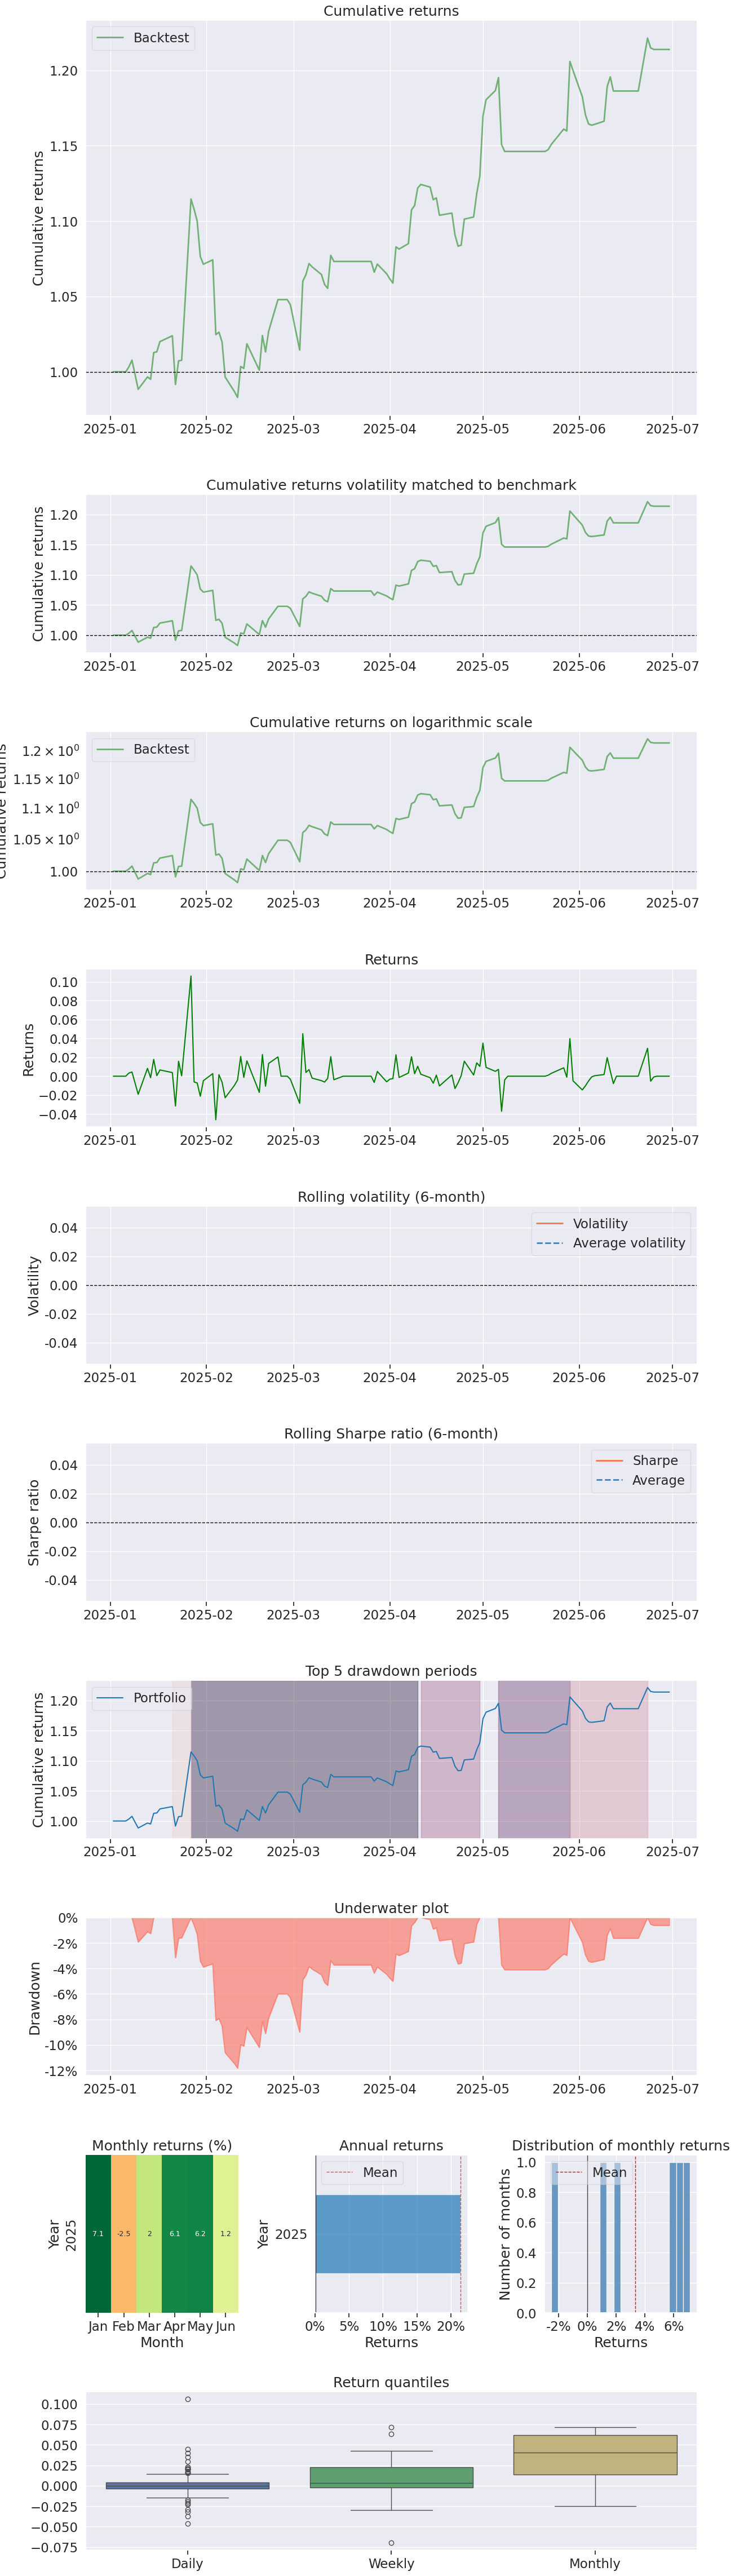

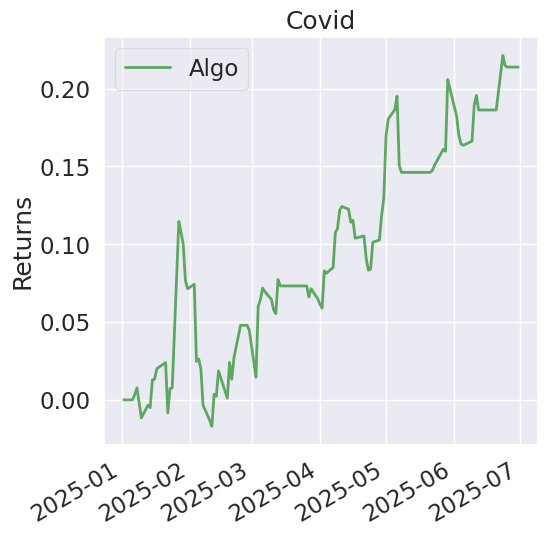

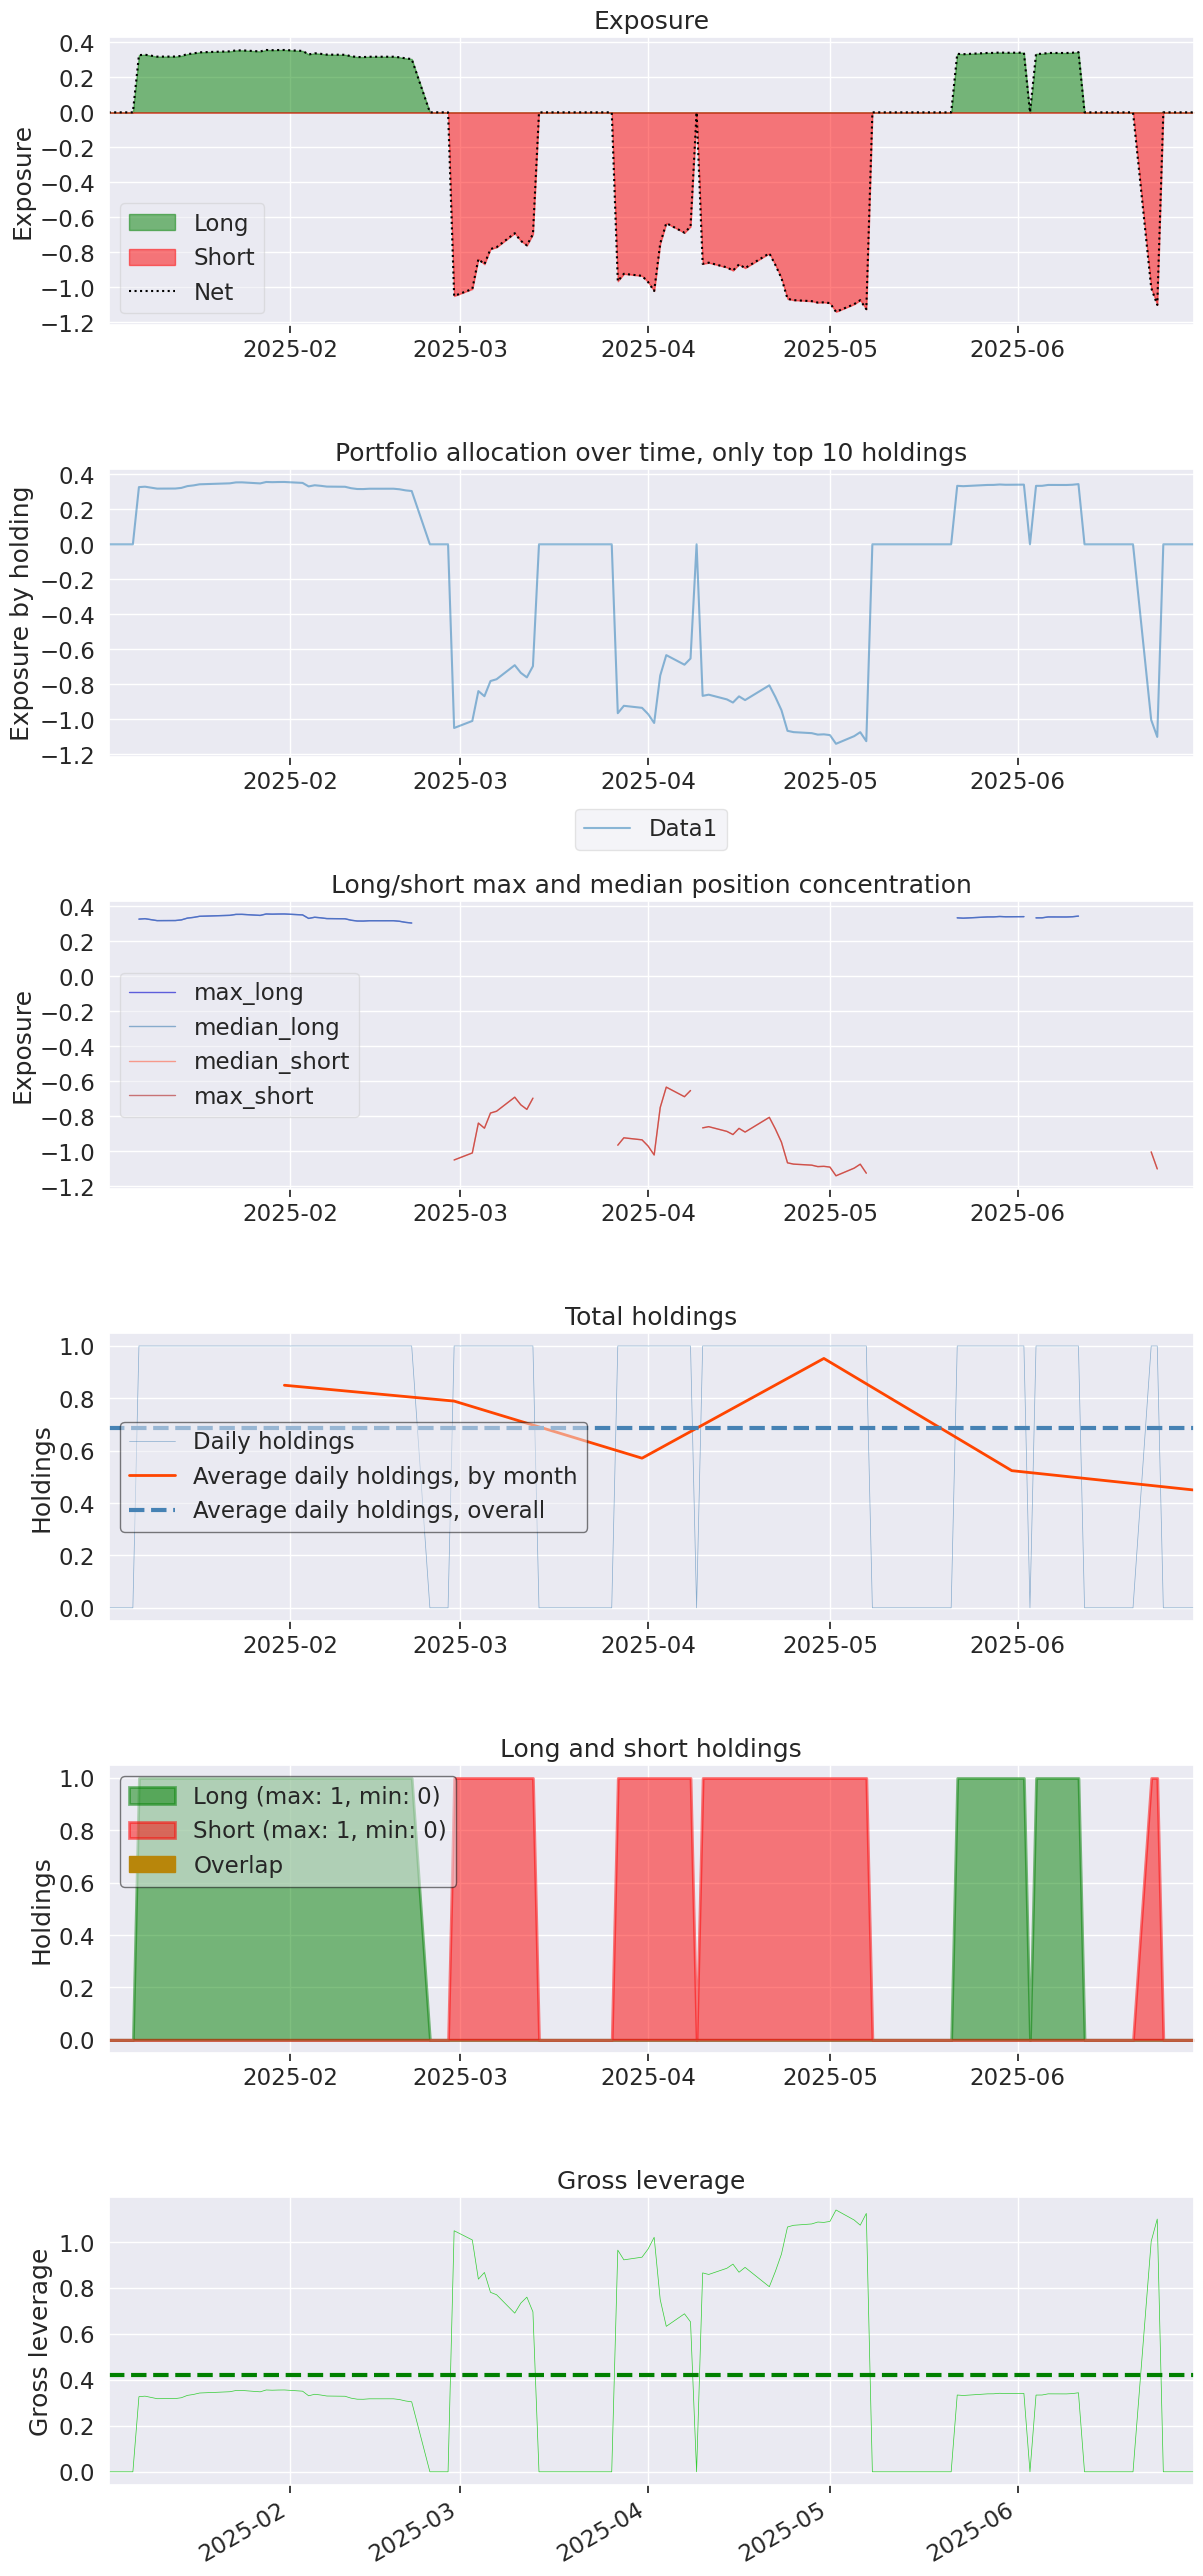

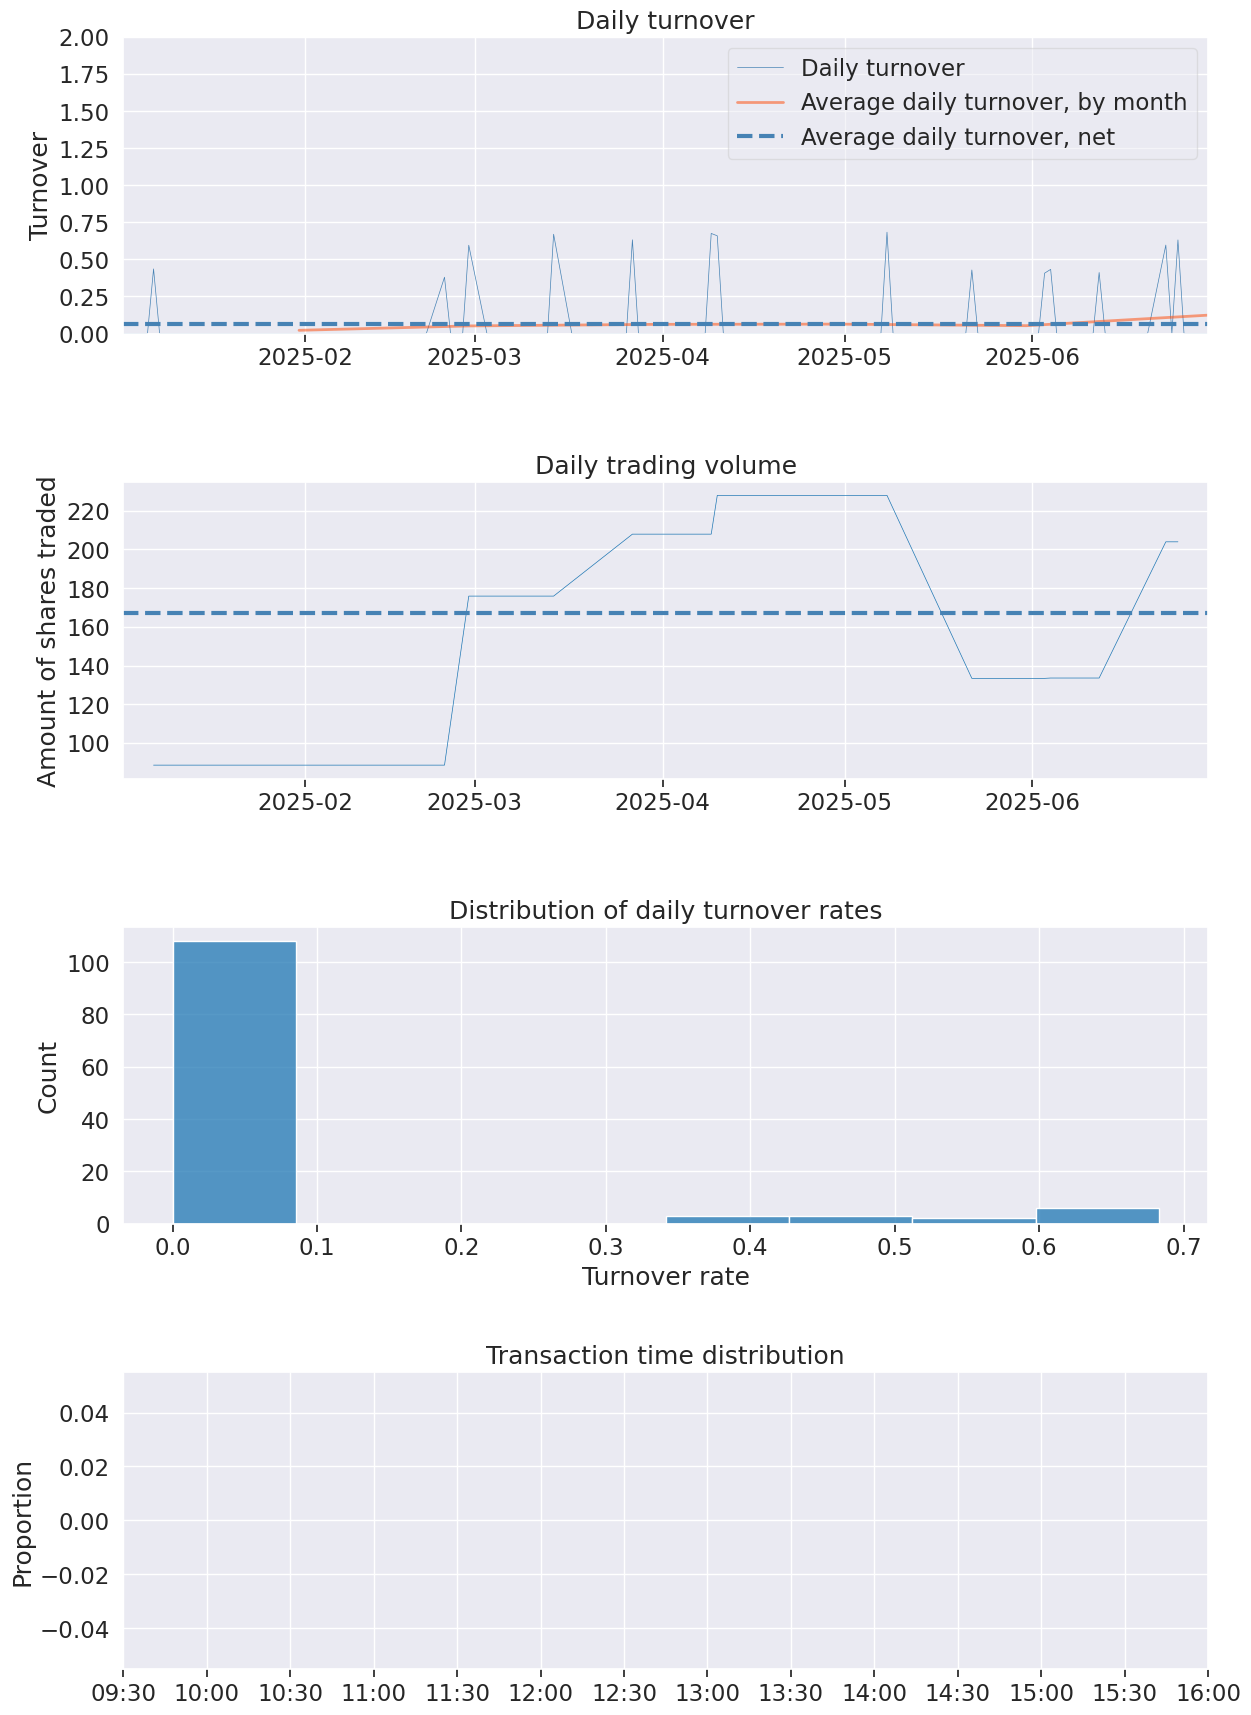

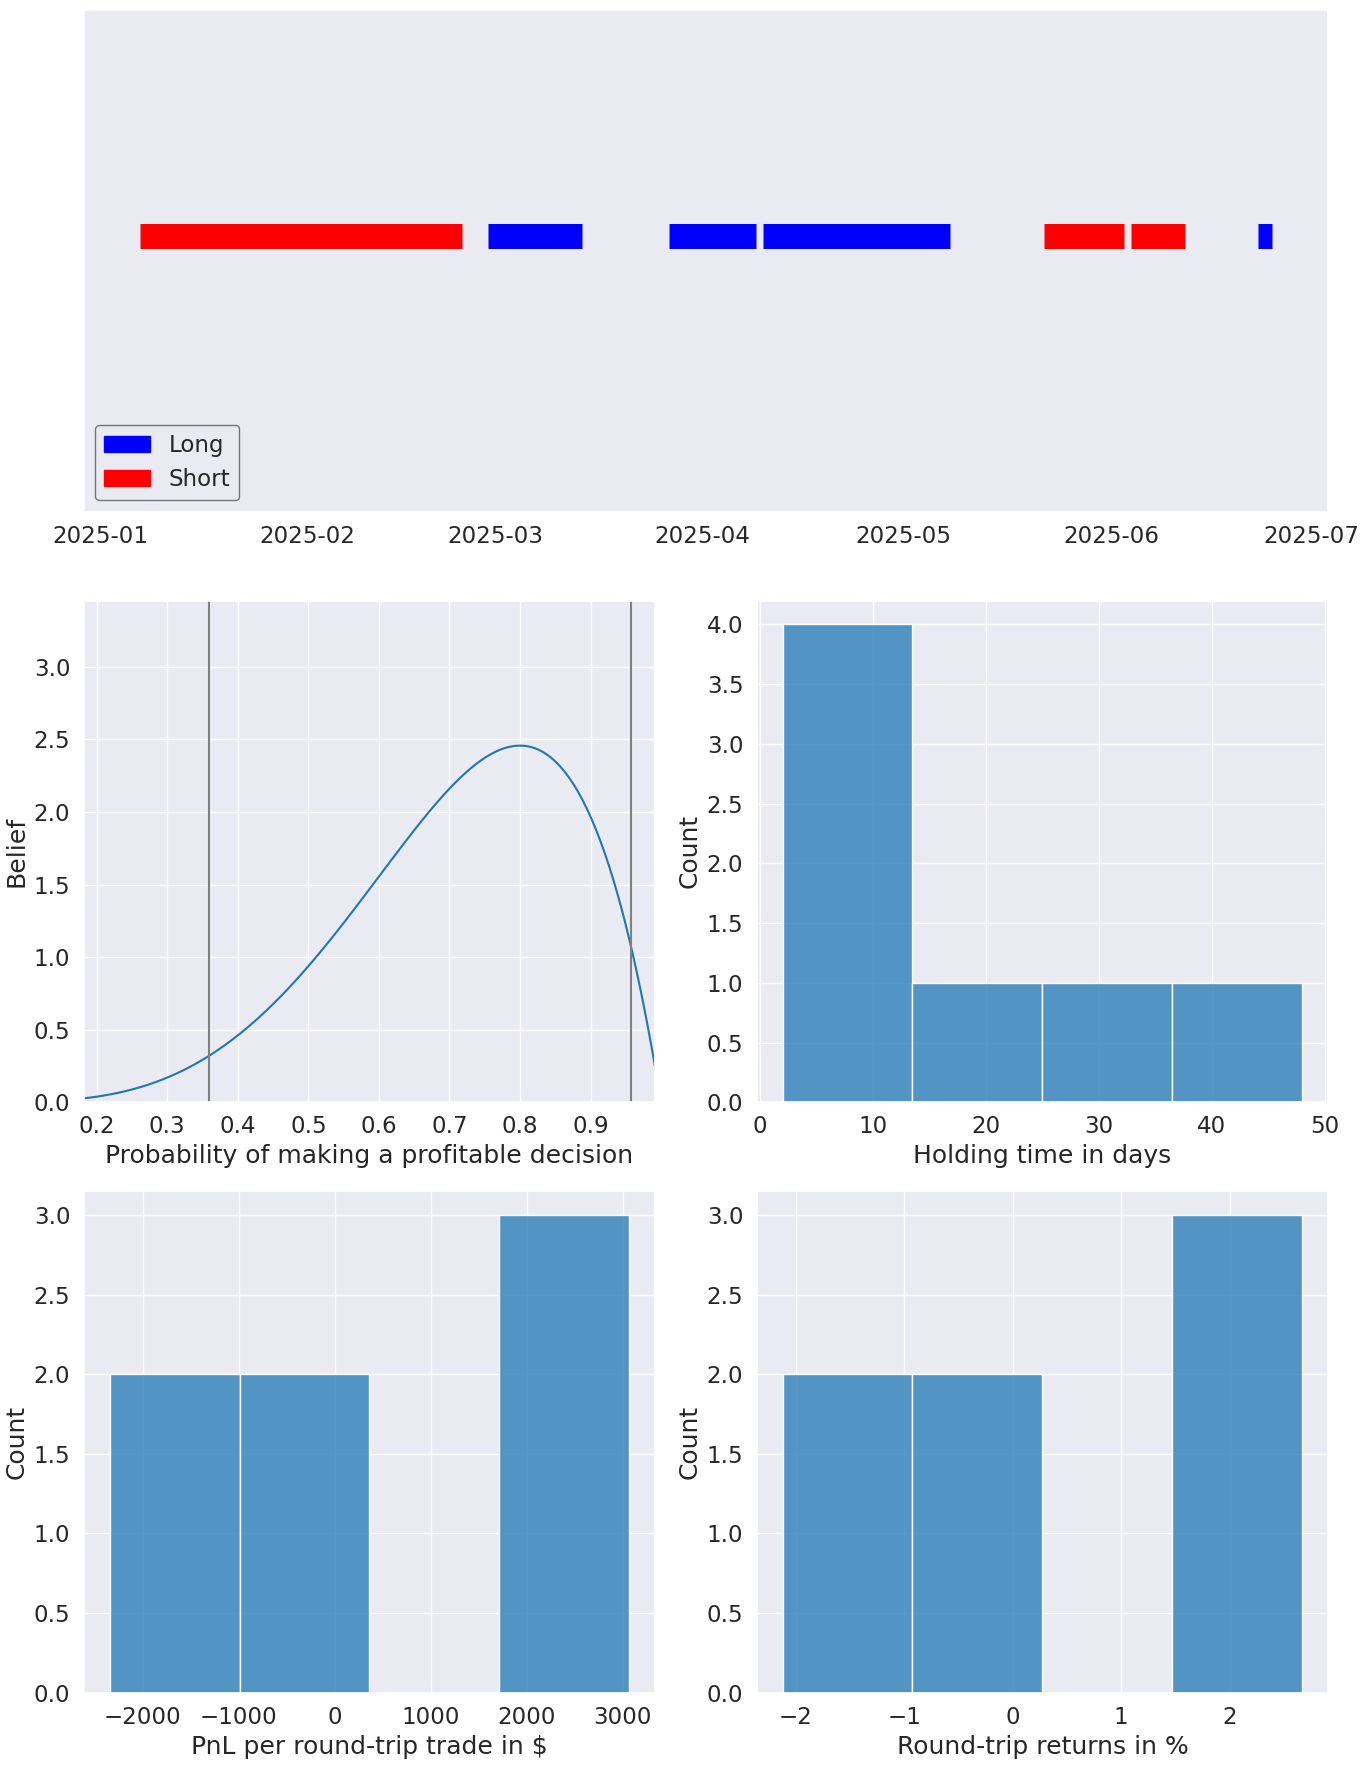

In [48]:
pf.create_full_tear_sheet(
    returns,
    positions,
    transactions,
    round_trips=True,
    estimate_intraday=False,
)